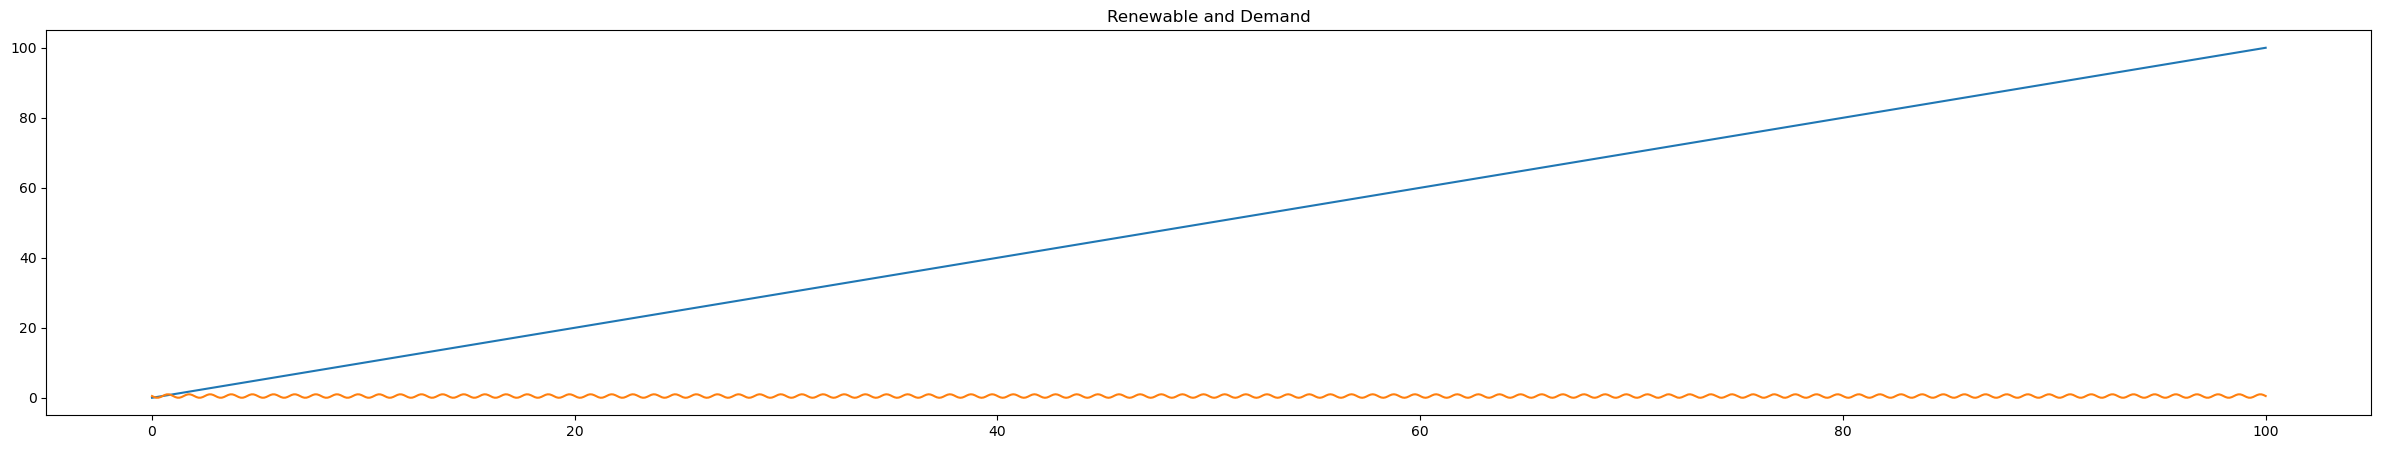

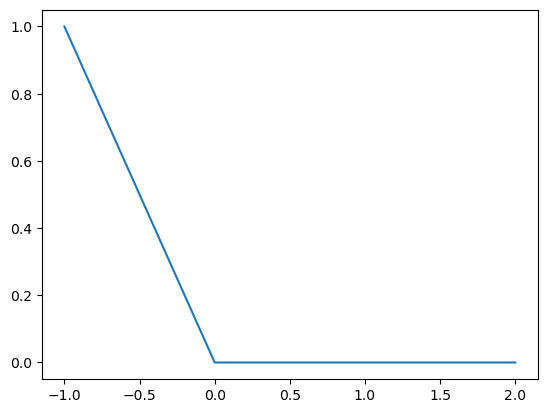

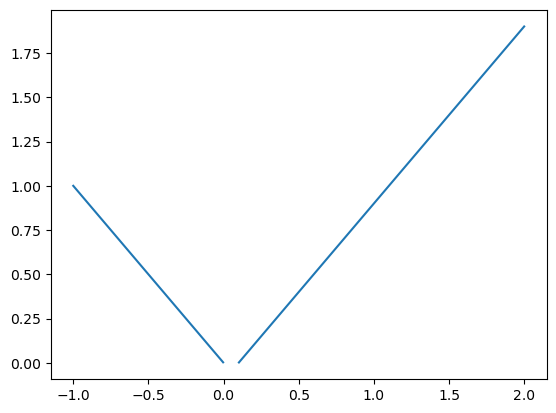

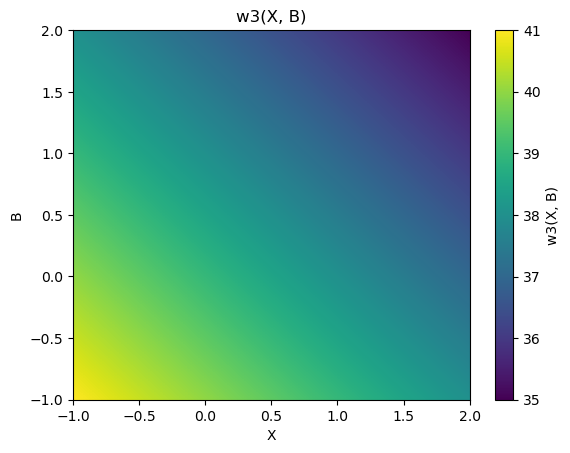

In [117]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline, interp1d
from matplotlib import pyplot as plt

Bmax = 0.1
D = lambda t: t
Ddot = lambda t : 1
R = lambda t: -0.5 * np.sin(2*np.pi*t) + 0.5
C = 0.5 * 0.01 + 0.5 * 0.01

penalty = 1
def w1(X):
    if X < 0:
        return -penalty * X
    return 0

def dw1dX(X):
    if X < 0:
        return -penalty
    return 0

def w2(B):
    if B < 0:
        return -penalty * B
    if B > Bmax:
        return penalty * (B - Bmax)
    
def dw2dB(B):
    if B < 0:
        return -penalty
    if B > Bmax:
        return penalty
    return 0

def w3(X, B, D):
    if X + B < D:
        return -penalty * (X + B - D)
    if X + B > D + Bmax:
        return penalty * (X + B - D - Bmax)
    return 0

def dw3dX(X, B, D):
    if X + B < D:
        return -penalty
    if X + B > D + Bmax:
        return penalty
    return 0

def dw3dB(X, B, D):
    if X + B < D:
        return -penalty
    if X + B > D + Bmax:
        return penalty
    return 0

t = np.linspace(0, 100, 1000)

plt.figure(figsize=(30, 5))
plt.title("Renewable and Demand")
plt.plot(t, D(t), label='D(t)')
plt.plot(t, R(t), label='S(t)')
plt.show()

X = np.linspace(-1, 2, 1000)
B = np.linspace(-1, 2, 1000)


plt.plot(X, np.vectorize(w1)(X), label='w1(X)')
plt.show()

plt.plot(B, np.vectorize(w2)(B), label='w2(B)')
plt.show()

xmesh, bmesh = np.meshgrid(X, B)
plt.pcolormesh(xmesh, bmesh, np.vectorize(w3)(xmesh, bmesh, D(39)), shading='auto')
plt.colorbar(label='w3(X, B)')
plt.xlabel('X')
plt.ylabel('B')
plt.title('w3(X, B)')
plt.show()






In [119]:
def state_equations(t, x, u_interp):
    X, B = x
    
    prod = R(t) + u_interp(t)
    return np.array([prod, prod - Ddot(t)])

def costate_equations(t, x):
    X, B = x
    return np.array([dw1dX(X) + dw3dX(X, B, D(t)), dw2dB(B) + dw3dB(X, B, D(t))])
    

def optimal_control(p1, p2):
    return (p1 + p2) / (2*C)

t_f = 100
state0 = np.array([0.5, 0])
costate0 = np.array([0, 0])
t_eval = np.linspace(0, t_f, 1000)

u = np.zeros(len(t_eval))

max_step = 0.5

epsilon = 1e-6
test = epsilon + 1

maxiter = 100

iter = 0
while test > epsilon:
    iter += 1
    if iter > maxiter:
        print("Max iterations reached")
        break

    u_old = u.copy()
    print(u_old.shape)
    u_interp = interp1d(t_eval, u_old, kind='linear', fill_value="extrapolate")

    state_sol = solve_ivp(state_equations, y0=state0, t_span=[0, t_f], t_eval=t_eval, args=(u_interp,), max_step=max_step)
    costate_sol = solve_ivp(costate_equations, y0=costate0, t_span=[t_f, 0], t_eval=t_eval[::-1], max_step=max_step)

    X = np.clip(state_sol.y[0], 0, np.inf)
    B = np.clip(state_sol.y[1], 0, Bmax)
    u = optimal_control(X, B)
    
    # Use clip instead of soft constraints?\
    

    test = abs(u - u_old).sum()

(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
Max iterations reached


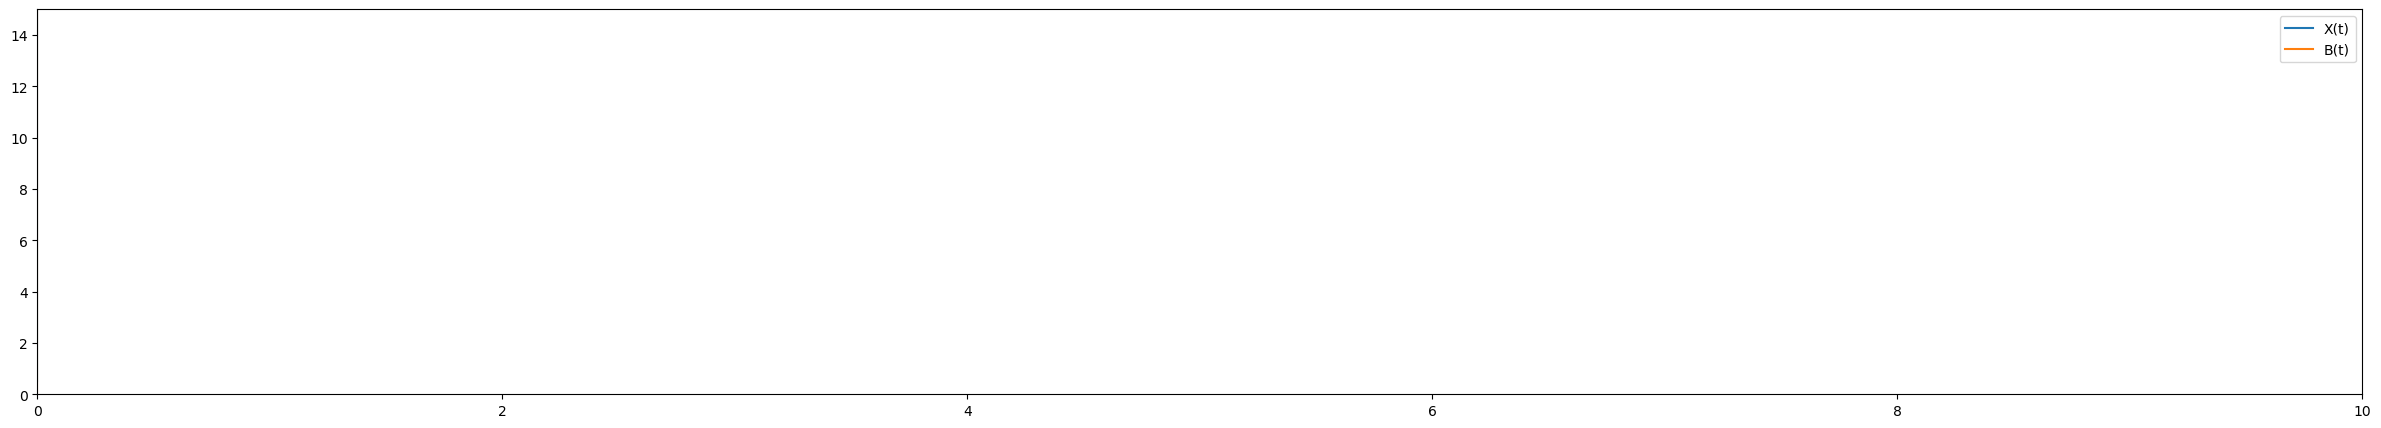

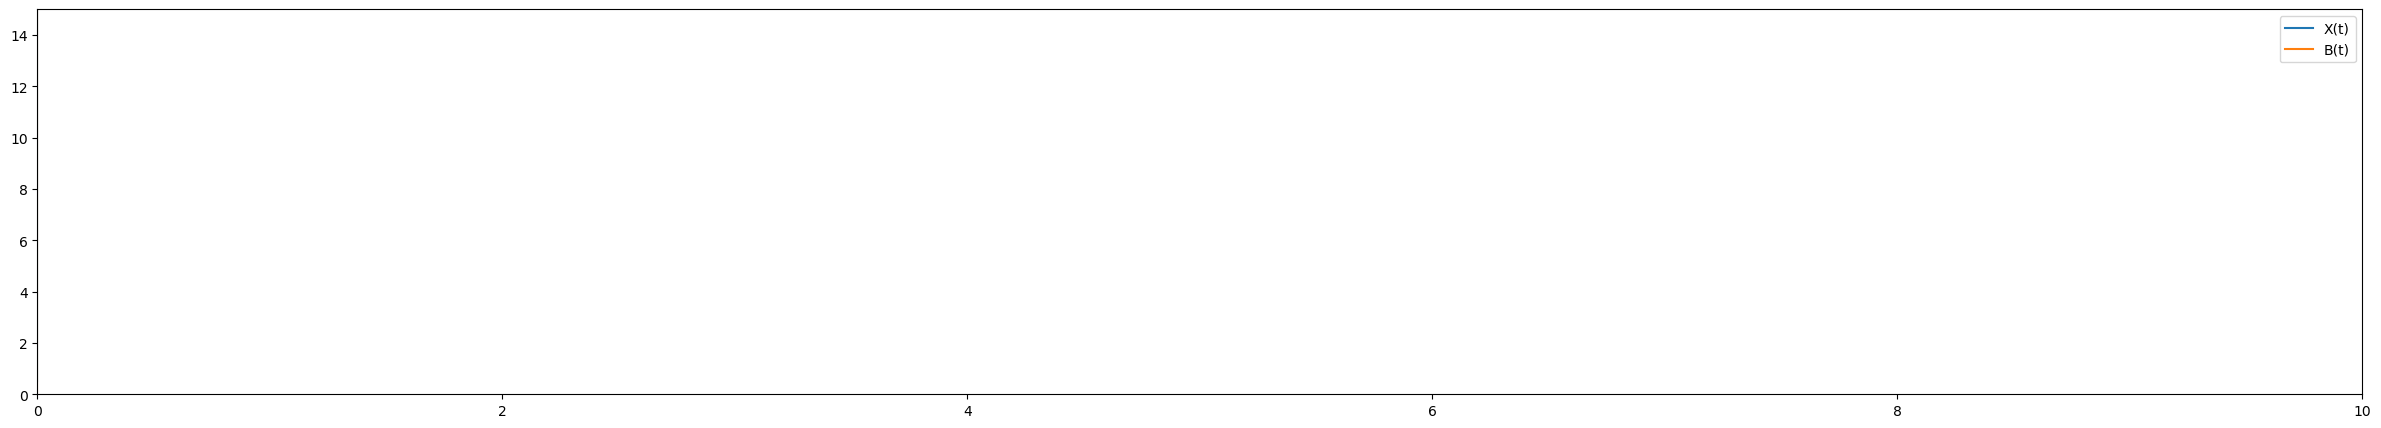

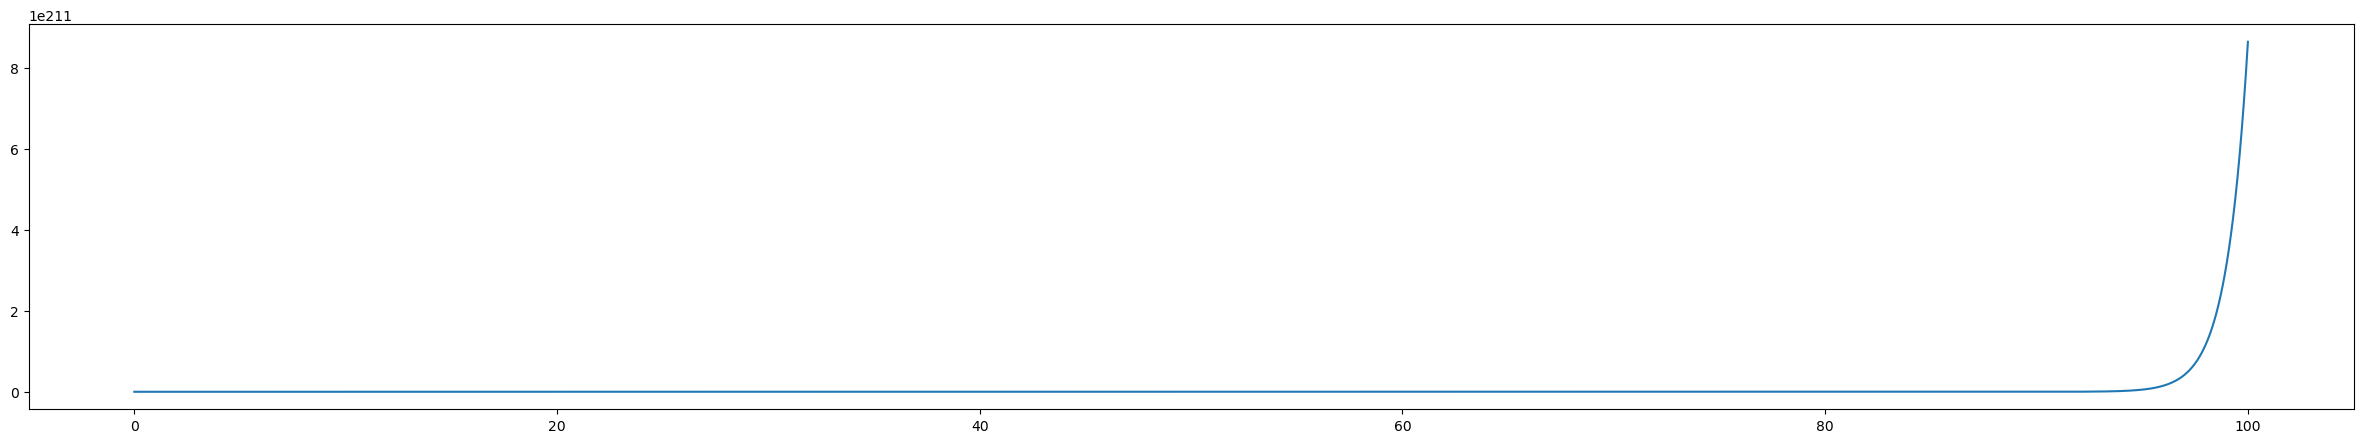

In [120]:
plt.figure(figsize=(30, 5))

plt.plot(t_eval, X, label='X(t)')
plt.plot(t_eval, state_sol.y[1], label='B(t)')
plt.xlim(0, 10)
plt.ylim(0, 15)
plt.legend()
plt.show()

plt.figure(figsize=(30, 5))
plt.plot(t_eval, state_sol.y[0], label='X(t)')
plt.plot(t_eval, state_sol.y[1], label='B(t)')
plt.xlim(0, 10)
plt.ylim(0, 15)
plt.legend()
plt.show()

plt.figure(figsize=(30, 5))
plt.plot(t_eval, u, label='u(t)')
plt.show()